In [209]:
import math
import matplotlib.pyplot as plt
import operator
import torch
from functools import partial

In [41]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [44]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [64]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Meanshift clustering algorithm
>The idea is to use the concepts of broadcasting, multiplication, gpu acceleration in the implementation

### create the data

In [824]:
n_clusters = 7
n_samples = 500

In [825]:
centroids = torch.rand(n_clusters, 2)*70-35

In [826]:
centroids

tensor([[-20.544,  -2.656],
        [  0.961,  25.602],
        [-21.740, -19.664],
        [ 24.189, -11.879],
        [ 11.812,  -3.914],
        [ 22.061,  24.954],
        [  2.041,  -6.196]])

In [827]:
centroids.shape

torch.Size([7, 2])

In [828]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

>We'll use a multivariate normal distribution, here bivariate, to generate points $(x_i, y_i)$ around the centroids, the variables won't be correlated so the covariance matrix should be diagonal, with variance $v$ each:<br>
*(The first argument is the mean, ie a centroid, and the second argument is the covariance matrix (here diagonal), then in the sample() method we specify the number of points to draw around this mean with the variance given in the covariance matrix)*

In [829]:
v = 5.0
u = MultivariateNormal(centroids[0], torch.diag(tensor([v,v])))

In [830]:
g = u.sample((n_samples,))

In [831]:
g.shape

torch.Size([500, 2])

In [832]:
def sample(m, v): return MultivariateNormal(m, torch.diag(tensor([v,v]))).sample((n_samples,))

In [833]:
v = 11.

In [834]:
clouds = [sample(c, v) for c in centroids]
data = torch.cat(clouds)
data.shape

torch.Size([3500, 2])

In [835]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: fig,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        sample = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(sample[:,0], sample[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='r', mew=1)

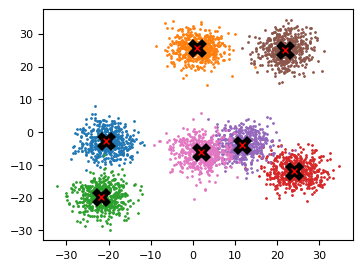

In [836]:
plot_data(centroids, data, n_samples)

### Mean Shift
> This algorithm does not need to know the number of centroids in advance, it requires a **bandwidth**, similarly to dbscan. <br>
And it works with clusters of any shape.

> What we are looking to do is measure the distance between each point and the rest of the points and weight each two-by-two distance with the gaussian. A neighbor point will have a weight closer to 1 vs a far away point will have a weight tht tends towards 0.

> We can try various function shapes and see how they compare in efficiency. If we want the weighting to be normed, the function should integrate to 1

> Then, we will assign the weighted average x and weighted average

In [837]:
#barycentre
data.mean(0)

tensor([2.739, 0.893])

> We typically use a gaussian function: <br>
\begin{equation*}
\mathcal{N}(0,\,\sigma^{2}) = \frac{1}{\sqrt{2\pi} \sigma} \exp \left(-{\frac{x^2}{2\sigma^2}}\right)
\end{equation*}

>But other functions can work as well. The gaussian's standard deviation will be the bandwidth, meaning the characteristic distance within which a point will have an impact in the weighted sum. Another possibility would be to use a trianfular function, an inverse function, or a decreasing exponential function.

In [838]:
def gaussian(x, sig=2.5) : 
    return 1/(sig*(2*math.pi)**(0.5)) * torch.exp(-0.5*(x/sig)**2)

In [839]:
def tri(x, i=8):
    return (-(x/i)+1).clamp_min(0)

In [840]:
def exp_n(x, t=2.5):
    return torch.exp(-x/t)

In [841]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

> In order to use partially defined function as input of `plot_func()` we can use the `partial` method from `functools`. We can pass in the function name and specify the attributes we want to fix:

In [842]:
partial

functools.partial

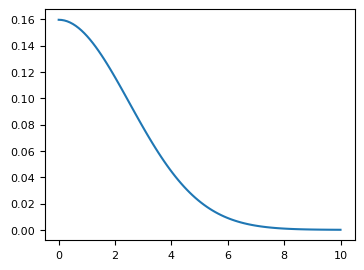

In [843]:
plot_func(partial(gaussian, sig=2.5))

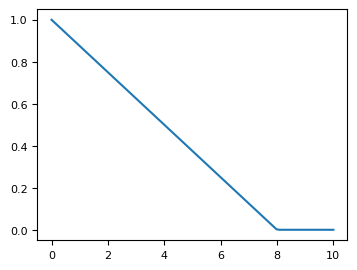

In [844]:
plot_func(tri)

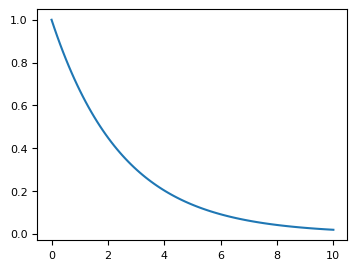

In [845]:
plot_func(exp_n)

In [846]:
X = data.clone()
x = data[0]

In [847]:
x.shape, X.shape, (x-X).shape

(torch.Size([2]), torch.Size([3500, 2]), torch.Size([3500, 2]))

>We can use a loop to calculate all values from the matrix X:

In [416]:
%%timeit
dist = torch.zeros(X.shape[0], X.shape[0])
for i,x in enumerate(X):
    dist[i] = ((x-X)**2).sum(1).sqrt()

269 µs ± 9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


> We can remove the loop and fasten the process by using a complete vectorial calculation:

In [175]:
X[...,None].shape, X.shape

(torch.Size([2500, 2, 1]), torch.Size([2500, 2]))

In [203]:
%timeit -n 10 ((X[...,None]-X.transpose(0,1))**2).sum(1).sqrt()

36 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> In order to remove the transpose step we can add the empty axis in between, the same broadcasting rule will apply:

In [484]:
X[:,None,:].shape, X.shape

(torch.Size([6, 1, 2]), torch.Size([6, 2]))

In [204]:
%timeit -n 10 ((X[:,None,:]-X)**2).sum(2).sqrt()

35.9 ms ± 797 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> We can try with `torch.einsum` as well:

In [193]:
%%timeit
Xt = torch.einsum('ij->ji', X)
Diff2 = (X[...,None] - Xt)**2
Dist = torch.einsum('ijk->ik', Diff2).sqrt()

36.1 ms ± 931 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [192]:
%timeit -n 10 Dist = torch.einsum('ijk->ik', (X[...,None] - torch.einsum('ij->ji', X))**2).sqrt()

37.7 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [194]:
%timeit -n 10 torch.sqrt(torch.einsum('ijk->ij',(X[:,None,:] - X)**2))

34.2 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> We can add the square step in einsum and the performance is the best:

In [205]:
%%timeit
Diff = X[:,None,:] - X
torch.sqrt(torch.einsum('ijk,ijk->ij',Diff,Diff))

25.5 ms ± 701 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> The fastest implementation in a function with the weighting function:

> We can build the following function that breaks down the operation point by point: <br>
(It is a very slow operation)

In [798]:
def calc_w(X, distrib):
    wei_X = torch.zeros(X.shape[0], X.shape[0])
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        wei_X[i] = weight
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new, wei_X

In [664]:
def calculate_weights(M, distrib):
    D = M[:,None,:] - M
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [665]:
weights = calculate_weights(X, gaussian)

In [666]:
weights

tensor([[    0.160,     0.000,     0.001,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.160,     0.020,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.020,     0.160,  ...,     0.000,     0.000,     0.000],
        ...,
        [    0.000,     0.000,     0.000,  ...,     0.160,     0.002,     0.000],
        [    0.000,     0.000,     0.000,  ...,     0.002,     0.160,     0.003],
        [    0.000,     0.000,     0.000,  ...,     0.000,     0.003,     0.160]])

> The next operation performs the weighted average $\frac{\sum_{i=0}^{n} \omega_i xi}{\sum_{i=0}^{n} \omega_i}$ for each point and replaces the weighted average of $x_i$ and $y_i$ by their new weighted average *(the einsum implementation is again much faster)* :

In [667]:
weights.shape, X.shape

(torch.Size([1500, 1500]), torch.Size([1500, 2]))

In [668]:
(X*weights[...,None]).sum(1).shape, weights.sum(1)[:,None].shape

(torch.Size([1500, 2]), torch.Size([1500, 1]))

In [669]:
%timeit -n 10 ((X*weights[...,None]).sum(1))/(weights.sum(0)[:,None])

5.99 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [670]:
%timeit -n 10 torch.einsum('jk,ijk->ik', X, weights[...,None])/torch.einsum('ij->j',weights)[:,None]

2.08 ms ± 856 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [785]:
X

tensor([[-13.451, -41.226],
        [-18.198, -30.833],
        [-15.268, -38.236],
        ...,
        [ 27.676,   4.900],
        [ 19.901,   1.975],
        [ 24.843,   8.009]])

In [811]:
r_s,_ = calc_w(X, gaussian)
r_s, _ = calc_w(r_s, gaussian)
r_s

tensor([[-11.644, -36.348],
        [-13.895, -33.210],
        [-12.157, -35.605],
        ...,
        [ 25.154,   4.688],
        [ 23.136,   3.707],
        [ 24.665,   5.328]])

In [812]:
w = calculate_weights(X, gaussian)
r_v = update_X(w, X)
w = calculate_weights(r_v, gaussian)
r_v = update_X(w, r_v)
r_v

tensor([[-11.644, -36.348],
        [-13.895, -33.210],
        [-12.157, -35.605],
        ...,
        [ 25.154,   4.688],
        [ 23.136,   3.707],
        [ 24.665,   5.328]])

In [813]:
(r_s-r_v).sum()

tensor(0.000)

In [814]:
def update_X(W, X): return torch.einsum('jk,ijk->ik', X, W[...,None])/torch.einsum('ij->j',W)[:,None]  
# def update_X(W, X): return((X*W[...,None]).sum(1))/(W.sum(0)[:,None])

In [672]:
%%timeit -n 10
weights = calculate_weights(X, gaussian)
update_X(weights, X)

21.4 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [889]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights = calculate_weights(X, func)
        X = update_X(weights, X)
    return X

In [890]:
%time X=meanshift(data, gaussian)

CPU times: user 1.3 s, sys: 350 ms, total: 1.65 s
Wall time: 415 ms


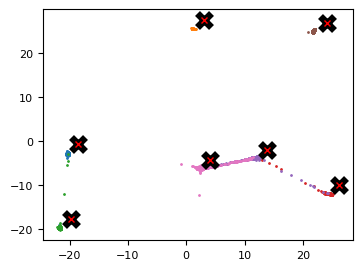

In [891]:
plot_data(centroids+2, X, n_samples)

> We can build the following function that breaks down the operation point by point to verify the results above: <br>
(It is a very slow operation)

In [850]:
def calc_w(X, distrib):
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new

In [851]:
def one_update(X):
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [736]:
%timeit -n 5 calc_w(X, gaussian)

124 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [892]:
def meanshift_slow(data):
    X = data.clone()
#     for it in range(5): X = calc_w(X, gaussian)
    for it in range(3): one_update(X)
    return X

In [893]:
%time X=meanshift_slow(data)

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.05 s


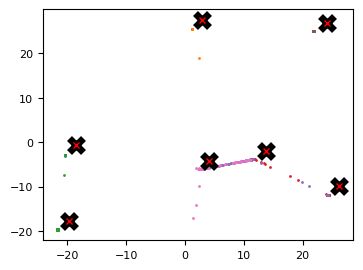

In [894]:
plot_data(centroids+2, X, n_samples)

CHECK THE PERFORMANCE OF THE VECT ALGO AND JEREMYS, HOW ARE THE POINTS POOLED...

### We can animate the process

In [895]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    

### *--- Quick drafting ---*

In [327]:
A = torch.tensor([0, 1, 2])

B = torch.tensor([[ 0,  1,  2,  3],
                  [ 4,  5,  6,  7],
                  [ 8,  9, 10, 11]])

In [328]:
A.shape, A[:,None].shape, B.shape

(torch.Size([3]), torch.Size([3, 1]), torch.Size([3, 4]))

In [329]:
A[:,None]*B, B*A[:,None]

(tensor([[ 0,  0,  0,  0],
         [ 4,  5,  6,  7],
         [16, 18, 20, 22]]),
 tensor([[ 0,  0,  0,  0],
         [ 4,  5,  6,  7],
         [16, 18, 20, 22]]))

In [265]:
(A[:,None]*B).sum(0), (A[:,None]*B).sum(1)

(tensor([20, 23, 26, 29]), tensor([ 0, 22, 76]))

In [270]:
torch.einsum('ij,ij->j',A[:,None],B), torch.einsum('ij,ij->i',A[:,None],B)

(tensor([20, 23, 26, 29]), tensor([ 0, 22, 76]))

Build the data and calculate the distances between each point and the rest of the points ( (n,n) difference) 

In [227]:
def samp(x): return torch.distributions.MultivariateNormal(x, torch.diag(torch.tensor([5.,5.]))).sample((10,))

In [228]:
samp(tensor([1.,2.]))

tensor([[ 0.886,  3.895],
        [-2.326,  3.220],
        [ 2.753, -0.873],
        [-3.342, -0.368],
        [ 5.698,  1.526],
        [ 0.465, -1.162],
        [ 2.884,  4.054],
        [ 8.553,  2.259],
        [-1.068,  2.933],
        [ 4.434,  4.213]])

In [222]:
samp.shape

torch.Size([10, 2])

In [225]:
cetr = torch.rand(5,2)

In [226]:
cetr

tensor([[0.374, 0.704],
        [0.107, 0.632],
        [0.842, 0.346],
        [0.499, 0.646],
        [0.352, 0.100]])

In [229]:
datt_l = [samp(c) for c in cetr]
datt =  torch.cat(datt_l)

In [230]:
datt.shape

torch.Size([50, 2])

In [235]:
(datt[:,None,:] - datt).shape

torch.Size([50, 50, 2])

In [237]:
#calc dist between each poitn and the rest
Di = datt[:,None,:] - datt
diss = torch.einsum('ijk,ijk->ij', Di, Di).sqrt()

In [239]:
diss.shape

torch.Size([50, 50])

In [243]:
rd = torch.zeros_like(diss)
for i, d in enumerate(datt):
    rd[i] = ((d-datt)**2).sum(1).sqrt()

In [248]:
(diss+1-rd).sum()

tensor(2500.)

In [254]:
def delta_equal(u, v, delta=1e-6):
    if (u-v).sum() < delta: return True
    else: return False

In [255]:
delta_equal(diss+1, rd)

False

In [512]:
A = tensor([[1,0],[1,0],[-1,0]])

B = tensor([[1, 2, 3],
            [4, 5, 6],
            [7, 8, 9]])

In [513]:
A, B

(tensor([[ 1,  0],
         [ 1,  0],
         [-1,  0]]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]))

In [514]:
A.shape, B.shape, A[...,None].shape, B[:,None,:].shape

(torch.Size([3, 2]),
 torch.Size([3, 3]),
 torch.Size([3, 2, 1]),
 torch.Size([3, 1, 3]))

In [515]:
A*B[...,None]

tensor([[[ 1,  0],
         [ 2,  0],
         [-3,  0]],

        [[ 4,  0],
         [ 5,  0],
         [-6,  0]],

        [[ 7,  0],
         [ 8,  0],
         [-9,  0]]])